In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
cd '/content/drive/MyDrive/EECS 598 Adv. ML/final_project/first_model'

/content/drive/.shortcut-targets-by-id/1jgtlMlObkEDJskwSwPdeQSDe5B234rbW/EECS 598 Adv. ML/final_project/first_model


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf


from keras.preprocessing import image
import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
%matplotlib inline

# import torchattacks
from keras.applications import vgg16
from torchvision.models import vgg16
import torch

In [ ]:
# model = vgg16.VGG16(weights='imagenet')

In [12]:
model = vgg16(pretrained=True)

In [13]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
  
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [14]:
adv_dev = load_set('adv_Flickr_8k.devImages.txt')

In [ ]:
adv_dev

{'1579798212_d30844b4c5',
 '1679557684_50a206e4a9',
 '2090545563_a4e66ec76b',
 '2391812384_7429b5e567',
 '2490687446_9d46fdf5a9',
 '2596619849_7b635dd310',
 '2635164923_2a774f7854',
 '269650644_059a84ece5',
 '2735792721_b8fe85e803',
 '2987328689_96a2d814f1',
 '2992614450_b5a6692239',
 '3393035454_2d2370ffd4',
 '3484841598_e26ee96aab',
 '3515904775_f8acc5909e',
 '3582685410_05315a15b8',
 '3583321426_f373c52161',
 '3616808182_fb4eaec778',
 '3652150541_8fb5a3a5d1',
 '3665179773_dd217416fc',
 '3695064885_a6922f06b2'}

In [15]:
def projected_gradient_descent(model, x, y, loss_fn, num_steps, step_size, step_norm, eps, eps_norm,
                               clamp=(0,1), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    targeted = y_target is not None
    num_channels = x.shape[1]

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        prediction = model(_x_adv)
       
        loss = loss_fn(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # Note .view() assumes batched image data as 4D tensor
                gradients = _x_adv.grad * step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
                    .norm(step_norm, dim=-1)\
                    .view(-1, num_channels, 1, 1)

            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], -1).norm(norm, dim=1)
            scaling_factor[mask] = eps

            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, 1, 1, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


tensor([740, 796, 514, 981, 792, 608, 870, 515, 880, 615])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


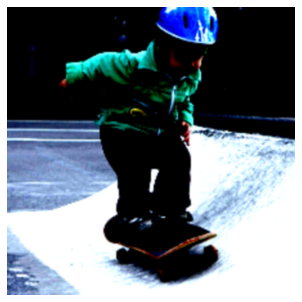

tensor([233, 433, 801, 447, 929, 898, 723, 731, 522, 971])


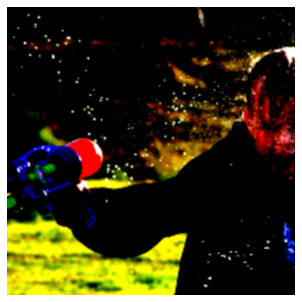

tensor([255, 217, 170, 515, 177, 522, 797, 841, 514, 608])


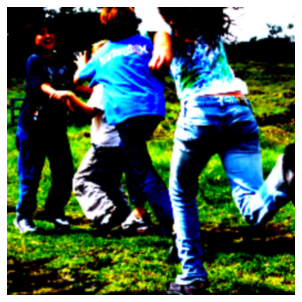

tensor([413, 286, 671, 264,  22, 792, 825, 796, 880, 491])


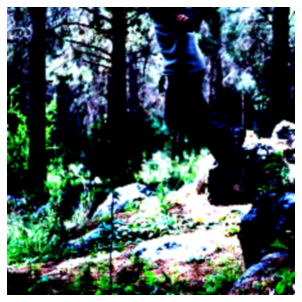

tensor([232, 263, 229, 258, 264, 257, 805, 230, 157, 231])


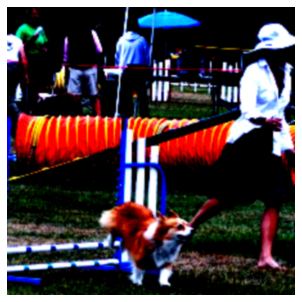

tensor([236, 254, 246, 178, 176, 212, 170, 208, 255, 177])


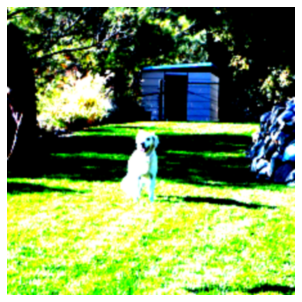

tensor([256, 245, 214, 227, 205, 210, 219, 212, 232, 217])


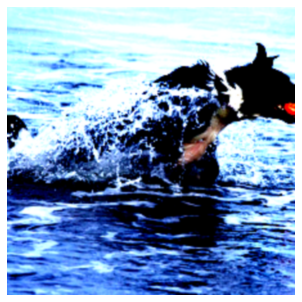

tensor([728, 862, 882, 733, 870, 879, 880, 523, 456, 843])


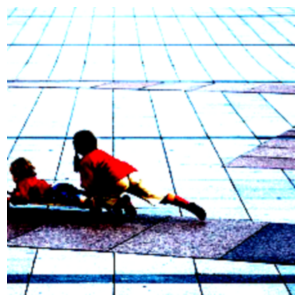

tensor([360, 200, 676, 244, 154, 255, 208, 219, 205, 256])


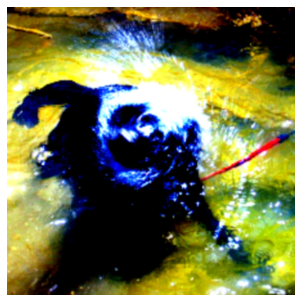

tensor([723, 838, 836, 585, 684, 902, 593, 982, 487, 447])


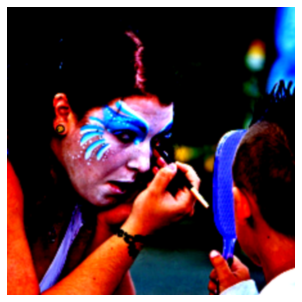

tensor([975, 327, 974, 360, 792, 394, 150,  34, 391, 979])


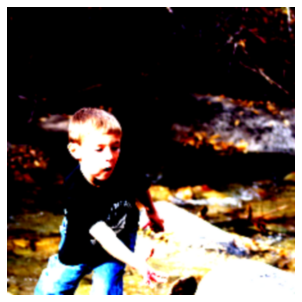

tensor([518, 863, 444, 919, 733, 488, 600, 880, 970, 671])


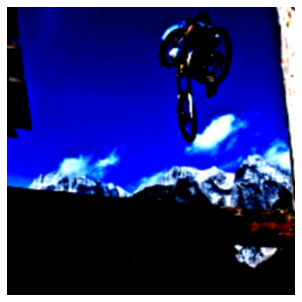

tensor([419, 981, 838, 596, 610, 678, 523, 429, 652, 518])


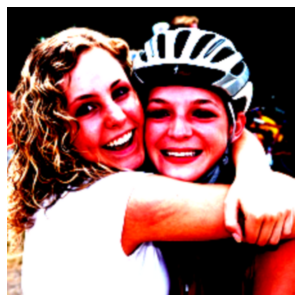

tensor([514, 880, 768, 560, 843,  63, 752, 805, 981, 429])


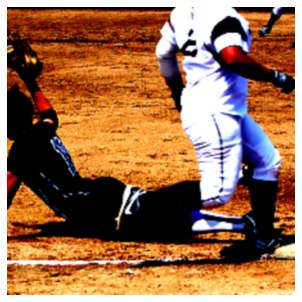

tensor([733, 130, 801, 327, 433, 977, 445, 862, 842, 562])


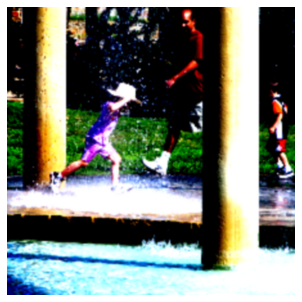

tensor([529, 842, 112, 987, 838, 977, 929, 435, 876, 971])


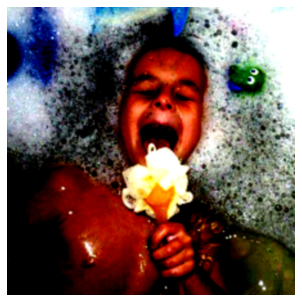

tensor([880, 792, 746, 791, 835, 795, 537, 704, 873, 646])


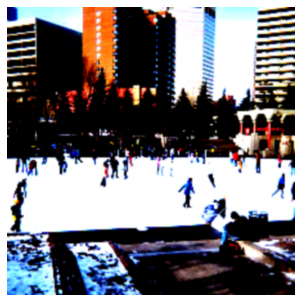

tensor([348, 349, 825, 649, 500, 976, 671, 979, 972, 970])


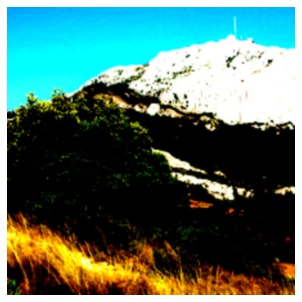

tensor([898, 972, 578, 655, 445, 838, 977, 638, 842, 639])


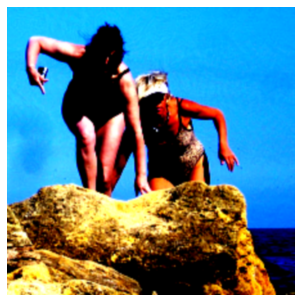

tensor([882, 678, 841, 791, 463, 643, 731, 452, 823, 793])


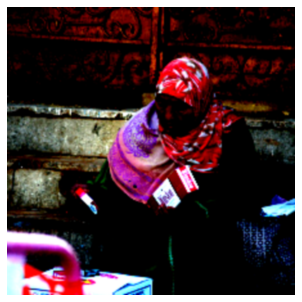

In [62]:
for j in adv_dev:
  img_path = 'Flicker8k_Dataset/' + str(j) + '.jpg'
  img = Image.open(img_path)

  
  centre_crop = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
  

  preds = model(Variable(centre_crop(img).unsqueeze(0)))
  print(preds[0].sort()[1][-10:])
  x = Variable(centre_crop(img).unsqueeze(0))
  y = preds[0].sort()[1][-10:]
  
  y = preds[0]

  y = torch.reshape(torch.argmax(torch.tensor(y), dim=0),(1,))
  loss_fn = nn.CrossEntropyLoss()
  
  x_adv = projected_gradient_descent(model, x, y, loss_fn, 
                                           num_steps=10, step_size=0.01,
                                           eps=0.01, eps_norm='inf',
                                           step_norm='inf')
 
  plt.grid('off')
  plt.axis('off')
  plt.gca().set_axis_off()
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  plt.margins(0,0)
  plt.gca().xaxis.set_major_locator(plt.NullLocator())
  plt.gca().yaxis.set_major_locator(plt.NullLocator())
  plt.imshow(transforms.ToPILImage()(x_adv[0]), interpolation="bicubic")
  plt.savefig('second_adv_examples_10_001/' + str(j) + '.png', bbox_inches='tight', pad_inches=0)
  plt.show()



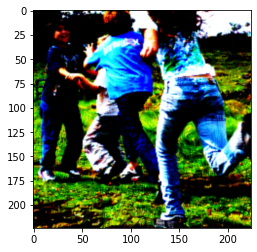

In [48]:
plt.imshow(transforms.ToPILImage()(x_adv[0]), interpolation="bicubic")

In [61]:
mkdir second_adv_examples_10_001